# Imports

In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna 
import os
from xgboost import XGBClassifier
from sklearn.metrics import recall_score,f1_score,confusion_matrix

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold
from random import randint

import math
from self_paced_ensemble import SelfPacedEnsembleClassifier

import warnings
warnings.filterwarnings('ignore')

In [108]:
features=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

df=pd.read_csv('../creditcard.csv')
df=df.rename(columns={'Class':'target'})

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Optuna tuning

In [242]:
def objective(trial: pd.DataFrame, X_train: pd.DataFrame, y_train: pd.DataFrame):
    
    params={'lambda': trial.suggest_loguniform('lambda', 1e-2, 5.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-2, 5.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.012,0.014,0.016,0.018, 0.02,0.05]),
        'n_estimators': trial.suggest_int('n_estimators',50,500),
        'max_depth': trial.suggest_categorical('max_depth', [2,3,5,7,9,11]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2021]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        }
    
    f1=[]
    recall=[]
    
    kf= KFold(n_splits=5)
     
    for train_idx,test_idx in kf.split(X_train,y_train):
        
        X_train_tuning,y_train_tuning= X_train.iloc[train_idx],y_train.iloc[train_idx]

        X_test_tuning,y_test_tuning= X_train.iloc[test_idx],y_train.iloc[test_idx]
        
        model=XGBClassifier(**params,n_jobs=-1)
        
        model.fit(X_train_tuning,y_train_tuning)
        
        predictions=model.predict(X_test_tuning)
        
        #f1.append(f1_score(y_test_tuning,predictions))
        
        recall.append(recall_score(y_test_tuning,predictions))
        
    return np.mean(recall)

# XGB model

In [243]:
def create_xgb(X_train: pd.DataFrame, y_train: pd.DataFrame):
    
    study=optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)
    
    params=study.best_params
    
    model=XGBClassifier(**params,n_jobs=-1)
    
    model.fit(X_train, y_train, verbose=0)
    
    return model

# Hardness func

In [244]:
def absolute_error(y_pred):
    
    return y_pred

In [245]:
def cross_entropy(y_pred):
    
    return np.log(y_pred)

In [246]:
def rmse(y_pred):
    
    return y_pred**2

# SPE 

In [247]:
def spe(X_maj: pd.DataFrame, X_min: pd.DataFrame, y_maj: pd.Series, y_min: pd.Series, estimator: int, n_estimators: int, k_bins: int):
    
    
    n_min=len(X_min)   
    
    step= (X_maj.hardness.max()-X_maj.hardness.min())/k_bins
    
    min_hardness= X_maj.hardness.min()
           
    # find idx for each bins
    bins=[]
    contributions = []
        
    for i_bins in range(k_bins):
            
        idx = X_maj[(X_maj.hardness >= i_bins*step + min_hardness ) & (X_maj.hardness < (i_bins+1)*step + min_hardness)].index
                
        if i_bins==(k_bins-1):
                    
            #idx= X_maj[X_maj.hardness >= i_bins*step + min_hardness].index
            idx= X_maj[X_maj.hardness == X_maj.hardness.max()].index
                
                
        bins.append(X_maj.loc[idx])
        contributions.append(X_maj.hardness.loc[idx].mean())
                
    # Update self-paced factor alpha
        
    alpha = np.tan(np.pi*0.5*(estimator/(n_estimators-1)))
        
    # Caculate sampling weight
    
    weights=[1/(x+alpha) for x in contributions]

    weights = [0 if math.isnan(x) else x for x in weights]
        
    # Caculate sample number from each bin
    sum_weights=sum(weights)
        
    n_sample_bins = [n_min*x/sum_weights for x in weights]
        
    n_sample_bins = [int(x)+1 for x in n_sample_bins]
        
    # Perform self-paced under-sampling
        
    sampled_bins=[]
        
    for i_bins in range(k_bins):
        
        if min(len(bins[i_bins]), n_sample_bins[i_bins]) > 0:
                
            sampled_bins.append(bins[i_bins].sample(n_sample_bins[i_bins],replace=True,random_state=randint(1,1000)))
            
            
            
    # create the new dataset
    
    X_maj= pd.concat(sampled_bins)
    y_maj= pd.DataFrame(0, index=np.arange(len(X_maj)), columns=['target']).target
            
    X_train=pd.concat([X_maj,X_min],axis=0)
    y_train=pd.concat([y_maj,y_min])
        
    return X_train, y_train

# Fit Model

In [248]:
def fit_model(train: pd.DataFrame, features: list, k_bins: int, n_estimators: int, hardness_func):
    
    X_maj,y_maj = train[train.target==0][features], train[train.target==0].target
    X_min,y_min = train[train.target==1][features], train[train.target==1].target
    
    # RandomUnderSampling for the first iteration
    X_train,y_train= train[features], train.target
    
    undersampler=RandomUnderSampler(sampling_strategy=1, random_state=randint(0,10000))
    
    X_train_rus, y_train_rus= undersampler.fit_resample(X_train, y_train)
    
    models=[]
    
    i=0
    
    for estimator in range(1,n_estimators):
        
        models.append(create_xgb(X_train_rus[features],y_train_rus))
        
        print('Model created')
        
        preds_maj=0
        
        for model in models:
            
            preds_maj+=model.predict_proba(X_maj[features])[:,1]
            
        preds_maj= preds_maj/len(models)
        
        print('Feature Calculation started')
        
        X_maj['proba']= preds_maj
        
        X_maj['hardness']= hardness_func(X_maj.proba)
        
        #resample based on self paced ensemble
        
        print('SPE started')
        
        X_train_rus,y_train_rus= spe( X_maj, X_min, y_maj, y_min, estimator, n_estimators, k_bins )
        
        i+=1
        print(i)
    
    return models
        

# Treshold Function

In [249]:
def tresholds(y_test,y_preds_proba):
    
    i=1
    plt.figure(figsize=(30,30))
    
    for treshold in [0.35,0.4,0.45,0.5,0.55,0.6] :
        y_preds_int=(y_preds>treshold).astype(int)
        plt.subplot(3,3,i)
        sns.heatmap(confusion_matrix(y_test,y_preds_int),annot=True,cmap="YlGnBu",annot_kws={"fontsize":50})
        plt.title(f'Treshold {treshold} | Recall: {np.round(recall_score(y_test,y_preds_int),3)}',fontsize=30)
        
        i+=1
        
    plt.tight_layout()
    sns.set(font_scale=1.4)
    plt.show()
        
        

# Cross Val Function

In [250]:
def cross_val(df: pd.DataFrame, features: list, hardness_func, istresh: bool=False):
    
    train=df[:200000]
    test=df[200000:]
    
    models=fit_model(train= train, features= features, k_bins=10, n_estimators=10, hardness_func=hardness_func)
    
    X_test,y_test= test[features],test.target
        
    y_preds_proba=0
    
    for model in models:
        
        y_preds_proba+=model.predict_proba(X_test)[:,1]
        
    y_preds_proba=y_preds_proba/len(models)
    
    
    if istresh:
        
        tresholds(y_test,y_preds_proba)
        
    else: 
        
        y_preds=(y_preds_proba>0.5).astype(int)
    
        print('\n')
        print(recall_score(y_test,y_preds))
        print('\n')
        print(confusion_matrix(y_test,y_preds))
    
    
    return y_preds_proba,models

Model created
Feature Calculation started
SPE started
1
Model created
Feature Calculation started
SPE started
2
Model created
Feature Calculation started
SPE started
3
Model created
Feature Calculation started
SPE started
4
Model created
Feature Calculation started
SPE started
5
Model created
Feature Calculation started
SPE started
6
Model created
Feature Calculation started
SPE started
7
Model created
Feature Calculation started
SPE started
8
Model created
Feature Calculation started
SPE started
9


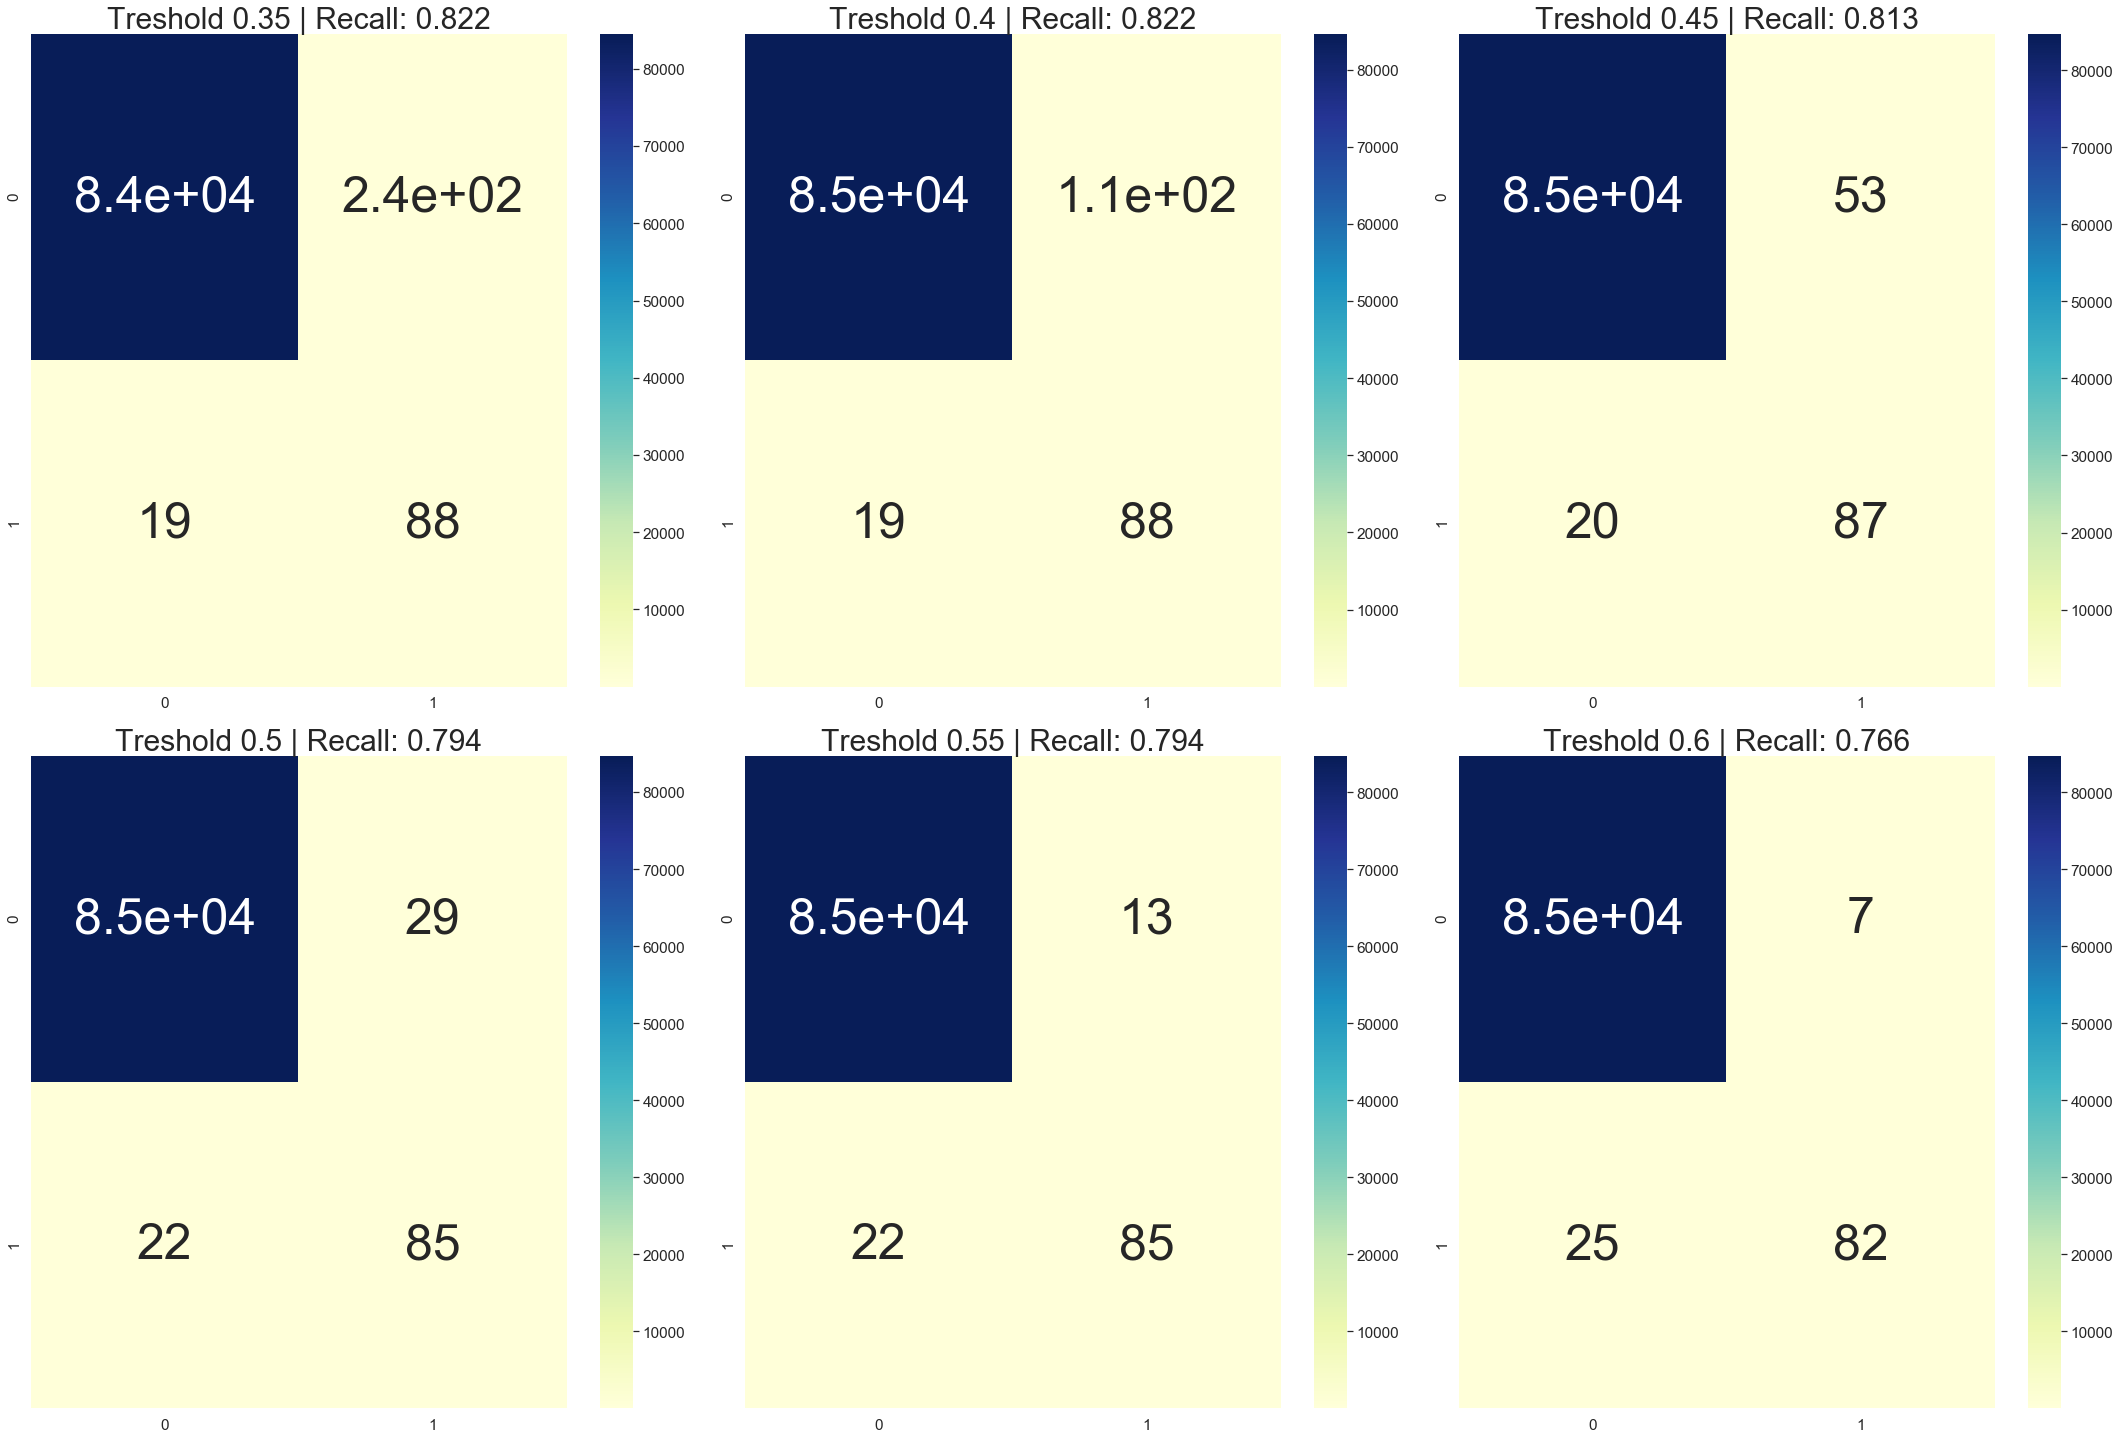

Wall time: 7min 51s


In [251]:
%%time
y_preds_proba,models=cross_val(df, features, hardness_func=rmse, istresh= True)